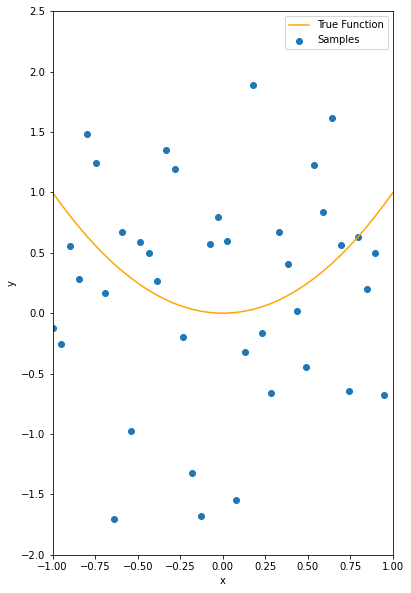

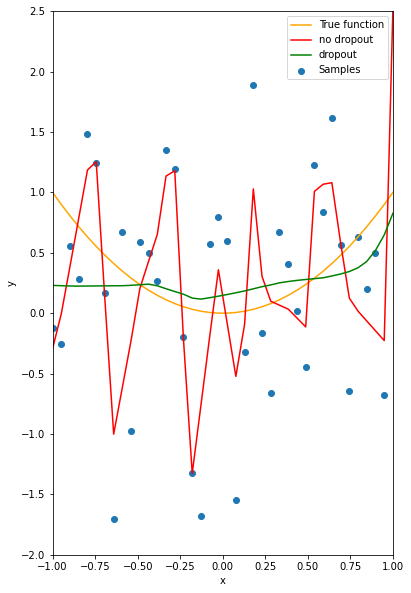

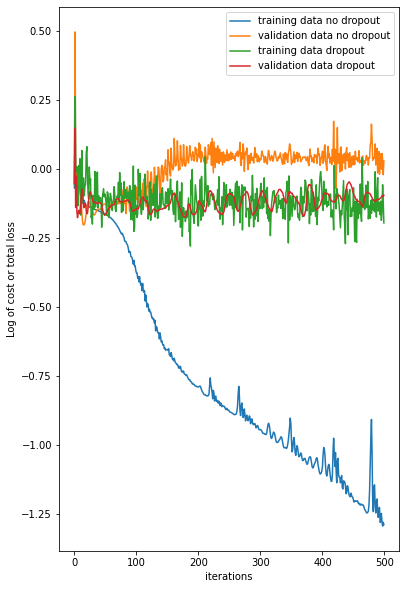

In [17]:

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0) 

# Create Data object

class Data(Dataset):
    
    # Constructor
    def __init__(self, N_SAMPLES=40, noise_std=1, train=True):
        self.x = torch.linspace(-1, 1, N_SAMPLES).view(-1, 1)
        self.f = self.x ** 2
        if train != True:
            torch.manual_seed(1)
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            torch.manual_seed(0)
        else:
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the data
    def plot(self):
        plt.figure(figsize = (6.1, 10))
        plt.scatter(self.x.numpy(), self.y.numpy(), label="Samples")
        plt.plot(self.x.numpy(), self.f.numpy() ,label="True Function", color='orange')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xlim((-1, 1))
        plt.ylim((-2, 2.5))
        plt.legend(loc="best")
        plt.show()

data_set = Data()
data_set.plot()


valid_data = Data(train=False)


class NN(nn.Module):
  def __init__(self,layers,d=0):
    super(NN,self).__init__()
    self.drop = nn.Dropout(p=d)
    self.list_=nn.ModuleList()
    for in_,out_ in zip(layers,layers[1:]):
      self.list_.append(nn.Linear(in_,out_))
    
  def forward(self,x):
    L = len(self.list_)
    for l,linear_ in zip(range(L),self.list_):
      if(l < L - 1):
        x = F.relu(self.drop(linear_(x)))
      else:
        x = linear_(x)
    return x

Layers = [1,150,150,1]
model = NN(Layers)
model_d = NN(Layers,0.5)

model_d.train()
optimiser = optim.Adam(model.parameters(),lr=0.01)
optimiser_d = optim.Adam(model_d.parameters(),lr=0.01)
criterion = nn.MSELoss()

LOSS={}
LOSS['training data no dropout']=[]
LOSS['validation data no dropout']=[]
LOSS['training data dropout']=[]
LOSS['validation data dropout']=[]

epochs = 500
def train(epochs):
  for epoch in range(epochs):
    yhat = model(data_set.x)
    yhat_d = model_d(data_set.x)
    loss = criterion(yhat,data_set.y)
    loss_d = criterion(yhat_d,data_set.y)

    LOSS['training data no dropout'].append(loss)
    LOSS['training data dropout'].append(loss_d)
    model_d.eval()
    LOSS['validation data no dropout'].append(criterion(model(valid_data.x),valid_data.y))
    LOSS['validation data dropout'].append(criterion(model_d(valid_data.x),valid_data.y))
    model_d.train()

    optimiser.zero_grad()
    optimiser_d.zero_grad()
    loss.backward()
    loss_d.backward()
    optimiser.step()
    optimiser_d.step()

train(epochs)

model_d.eval()

# Make the prediction

yhat = model(data_set.x)
yhat_drop = model_d(data_set.x)

# Plot the predictions for both models

plt.figure(figsize=(6.1, 10))

plt.scatter(data_set.x.numpy(), data_set.y.numpy(), label="Samples")
plt.plot(data_set.x.numpy(), data_set.f.numpy(), label="True function", color='orange')
plt.plot(data_set.x.numpy(), yhat.detach().numpy(), label='no dropout', c='r')
plt.plot(data_set.x.numpy(), yhat_drop.detach().numpy(), label="dropout", c ='g')

plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-1, 1))
plt.ylim((-2, 2.5))
plt.legend(loc = "best")
plt.show()

# Plot the loss

plt.figure(figsize=(6.1, 10))
for key, value in LOSS.items():
    plt.plot(np.log(np.array(value)), label=key)
    plt.legend()
    plt.xlabel("iterations")
    plt.ylabel("Log of cost or total loss")